# Notebook 2 — Heston Model as a State-Space Model + Bootstrap Particle Filter

**Goal of this notebook**

- Write the **Heston stochastic volatility model** in **discrete-time, state-space form**.
- Implement it using **Chopin's `particles` library** as a `StateSpaceModel`.
- Run a **bootstrap particle filter** to:
  - Estimate the *hidden variance path* \( V_t \) from returns.
  - Compute an *approximate log-likelihood* for a fixed parameter vector \( \theta \).

This corresponds to **Step 1** of the project:

> Implement a bootstrap filter to approximate the likelihood for given parameter vector θ.

We will start with:
- **Synthetic data** (simulated returns), so we can check if the filter roughly reconstructs the true volatility.
- Later, we will replace synthetic data with **S&P 500 data** and move to **parameter estimation**.


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')  # avoid clutter

import numpy as np
import matplotlib.pyplot as plt

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles.collectors import Moments

plt.style.use('ggplot')

print("particles version:", particles.__version__)


particles version: 0.3alpha


## 1. Heston model recap 

Continuous-time Heston model under the risk-neutral measure (simplified):

$$
\begin{aligned}
dS_t &= r S_t \, dt + \sqrt{V_t}\, S_t\, dW_1(t), \\
dV_t &= \kappa(\theta - V_t)\, dt + \sigma \sqrt{V_t}\, dW_2(t),
\end{aligned}
$$

with:
- $S_t$: asset price  
- $V_t$: variance (hidden / latent)  
- $r$: risk-free rate  
- $\kappa$: mean-reversion speed of variance  
- $\theta$: long-run variance  
- $\sigma$: vol of vol  
- $(W_1, W_2)$: Brownian motions with correlation $\rho$

We only **observe prices**, not $V_t$.

So we typically work with **log-returns**:

$$
R_t = \log S_t - \log S_{t-1}
$$

---

## 2. Discretisation (simple Euler scheme)

We consider discrete times $t = 0, \Delta t, 2\Delta t, \dots$.

We’ll use a **standard Euler discretisation** of the Heston SDE.

### 2.1 Variance dynamics (CIR process)

$$
V_t = V_{t-1} 
      + \kappa (\theta - V_{t-1}) \Delta t 
      + \sigma \sqrt{V_{t-1}\Delta t}\,\varepsilon_{2,t},
$$

where  
$\varepsilon_{2,t} \sim N(0,1)$.

### 2.2 Observation equation (log-returns)

Approximate:

$$
R_t \mid V_{t-1} \sim 
N\!\left(\left(r - \tfrac{1}{2}V_{t-1}\right)\Delta t,\;
       V_{t-1}\Delta t\right)
$$

(Using $V_{t-1}$ vs $V_t$ is a discretisation choice; both appear in the literature.)

---

## 3. State-space model structure

We choose the **state** as:

$$
X_t = V_t
$$

and the **observation** as:

$$
Y_t = R_t
$$

So the state-space model is:

- **State transition**  
  $$
  X_t \mid X_{t-1} 
  \sim \text{Euler-CIR}(X_{t-1})
  $$

- **Observation model**  
  $$
  Y_t \mid X_{t-1}
  \sim N\!\left((r - 0.5 X_{t-1})\Delta t,\; X_{t-1}\Delta t\right)
  $$

We will implement this model using Chopin’s `particles` library:

```python
class HestonSSM(ssm.StateSpaceModel):
    def PX0(self): ...
    def PX(self, t, xp): ...
    def PY(self, t, xp, x): ...


In [2]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import numpy as np

rng = np.random.default_rng(42)

# Parameters of the toy SSM
a = 0.9          # AR(1) coefficient for the hidden state
sigma_x = 0.5    # state noise std
sigma_y = 0.8    # observation noise std
T = 100          # number of time steps

# Simulate the latent state X_t
X = np.zeros(T)
Y = np.zeros(T)

X[0] = 0.0
for t in range(1, T):
    X[t] = a * X[t-1] + sigma_x * rng.normal()

# Simulate observations Y_t
Y = X + sigma_y * rng.normal(size=T)

X[:5], Y[:5]


(array([ 0.        ,  0.15235854, -0.38286937,  0.03064317,  0.49786121]),
 array([-0.72438324, -0.1501715 ,  0.65651327, -0.25436801,  1.08787366]))

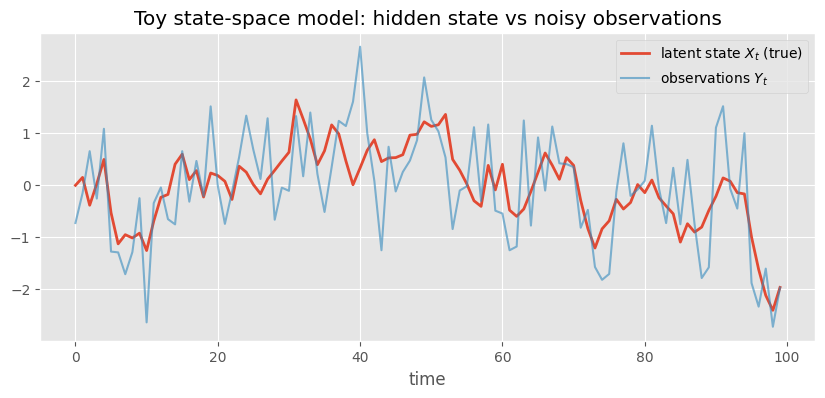

In [3]:
plt.figure(figsize=(10,4))
plt.plot(X, label="latent state $X_t$ (true)", linewidth=2)
plt.plot(Y, label="observations $Y_t$", alpha=0.6)
plt.xlabel("time")
plt.legend()
plt.title("Toy state-space model: hidden state vs noisy observations")
plt.show()


# Why Are the Heston Transition and Observation Distributions Normal?

To understand why the particle filter uses **Normal distributions** for both:

- the volatility transition \( V_t \mid V_{t-1} \), and  
- the return distribution \( R_t \mid V_{t-1} \),

we need to recall one key fact from stochastic calculus:

---

## 1. Brownian motion increments are Normal

By definition:

$$
W_{t+\Delta t} - W_t \sim N(0, \Delta t).
$$

So we write:

$$
dW_t \approx \sqrt{\Delta t}\, z_t, \qquad z_t \sim N(0,1).
$$

This single fact makes both parts of the Heston model Normal after discretization.

---

## 2. The Heston volatility SDE

The continuous-time volatility process is:

$$
dV_t = \kappa(\theta - V_t)\,dt \;+\; \sigma \sqrt{V_t}\,dW_t.
$$

Apply Euler–Maruyama discretization:

- \( dV_t \approx V_{t+\Delta t} - V_t \)
- \( dW_t \approx \sqrt{\Delta t}\, z_t \)

We get:

$$
V_{t+\Delta t} =
V_t + \kappa(\theta - V_t)\Delta t
+ \sigma \sqrt{V_t \Delta t}\, z_t.
$$

This is of the form:

$$
V_{t+1} = \text{deterministic term} + \text{Normal noise}.
$$

Therefore:

$$
V_{t+1} \mid V_t \sim 
N\!\Big(
V_t + \kappa(\theta - V_t)\Delta t,\;
\sigma^2 V_t \Delta t
\Big).
$$

This is why `PX` returns a Normal distribution.

---

## 3. The Heston return SDE

The paper gives the log-price SDE:

$$
d\ln S_t 
= \left(r - \tfrac12 V_t\right)dt 
+ \sqrt{V_t}\, dW_1(t).
$$

Apply Euler discretization:

$$
R_t = \ln S_t - \ln S_{t-1}
\approx
(r - \tfrac12 V_{t-1})\Delta t
+ \sqrt{V_{t-1}\Delta t}\, z_t.
$$

Since \( z_t \sim N(0,1) \), this is Normal:

$$
R_t \mid V_{t-1} \sim 
N\!\Big(
(r - \tfrac12 V_{t-1})\Delta t,\;
V_{t-1} \Delta t
\Big).
$$

This is why the `PY` method also returns a Normal distribution.

---

## 4. Core Insight

The Normality does **not** come from an assumption.

It comes from:

1. The Heston model being driven by Brownian motion  
2. Euler discretization turning each SDE into:

   $$
   \text{state}_{t+1} = \text{deterministic part} + \text{Gaussian noise}
   $$

3. A deterministic value plus Normal noise is Normal.

---

## 5. Summary

- Brownian motion increments are Normal.  
- Heston volatility and returns both involve Brownian increments.  
- Euler discretization preserves Normality.  
- Therefore:
  - \( V_{t+1} \mid V_t \) is Normal  
  - \( R_t \mid V_{t-1} \) is Normal  
- This is exactly why the particle filter uses:

```python
dists.Normal(loc=mean, scale=std)


In [23]:
class HestonSSM(ssm.StateSpaceModel):
    """ Heston state-space model for stochastic volatility. """

    def __init__(self, kappa, theta, sigma, rho, r, dt, v0):
        super().__init__()
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.r = r
        self.dt = dt
        self.v0 = v0

    # Prior on V0
    def PX0(self):
        return dists.Dirac(self.v0)

    # State transition V_t | V_{t-1}
    def PX(self, t, xp):
        xp = np.asarray(xp).reshape(-1)
        vp = np.maximum(xp, 1e-12)
        mean = vp + self.kappa*(self.theta - vp)*self.dt
        std  = self.sigma * np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)

    # Observation density R_t | V_{t-1}
    def PY(self, t, xp, x):
        if xp is None:  # for t=0 only
            return dists.Dirac(0.0)

        xp = np.asarray(xp).reshape(-1)
        vp = np.maximum(xp, 1e-12)
        mean = (self.r - 0.5 * vp) * self.dt
        std  = np.sqrt(vp * self.dt)
        return dists.Normal(loc=mean, scale=std)


In [24]:
heston = HestonSSM(kappa=2.0, theta=0.04, sigma=0.3, rho=-0.7, r=0.04, dt=1/252, v0=0.04)

true_states, data = heston.simulate(100)

true_states = np.array(true_states).flatten()
data = np.array(data).flatten()

# Remove t=0 dummy observation
true_states = true_states[1:]
data = data[1:]


## Plot simulated hidden volatility and returns

We visualize the simulated variance path `true_states` and the returns `data`
to confirm that the Heston model simulation behaves as expected.


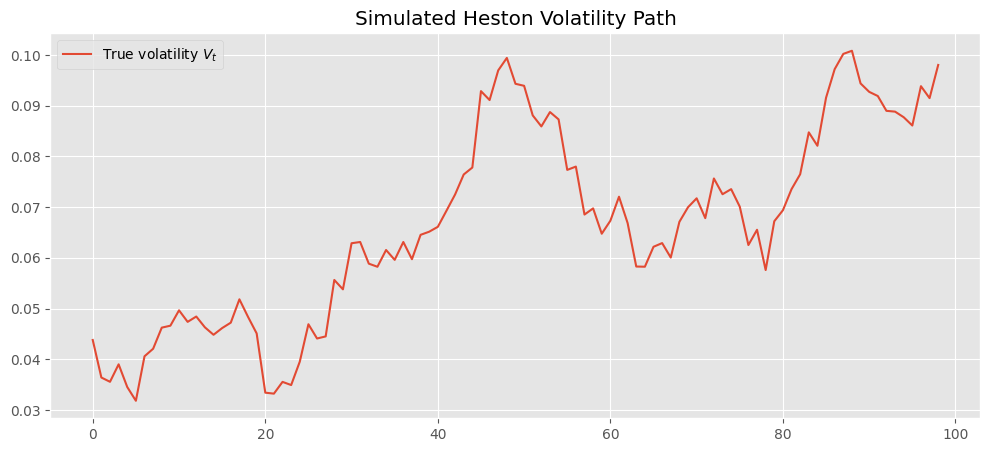

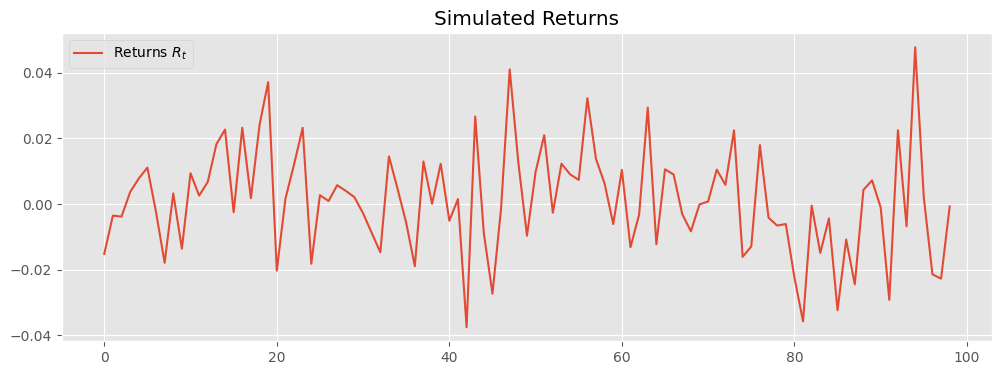

In [25]:
true_states = np.array(true_states).flatten()
data = np.array(data).flatten()

plt.figure(figsize=(12,5))
plt.plot(true_states, label="True volatility $V_t$")
plt.title("Simulated Heston Volatility Path")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(data, label="Returns $R_t$")
plt.title("Simulated Returns")
plt.legend()
plt.show()


## Bootstrap Particle Filter on Synthetic Heston Data

We now run the Bootstrap PF using Chopin's `particles` library.

This PF will:
- sample volatility particles using `PX`
- weight them using `PY`
- resample when ESS gets small
- provide an estimate of the hidden variance
- output an estimated log-likelihood


In [26]:
fk = ssm.Bootstrap(ssm=heston, data=data)

alg = particles.SMC(
    fk=fk,
    N=2000,
    resampling='systematic',
    collect=[Moments()]
)

alg.run()

print("Estimated log-likelihood:", alg.logLt)


IndexError: tuple index out of range